# Notebook to evaluate Theis solution with one well 
# using a circular unstructured grid

In [1]:
import numpy as np
import flopy as fp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, shutil
from matplotlib.backends.backend_pdf import PdfPages

## Define a location and model name

In [2]:
model_dir = 'theis_flopy_mf6_unstruc_circ'
model_name = 'theis'

## Set up the simulation

In [3]:
# create simulation
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)


In [4]:
# create tdis package
tdis_rc = [(86400.0, 75, 1.2)]
tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             perioddata=tdis_rc)

In [5]:
# create gwf model
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

In [6]:
# create iterative model solution and register the gwf model with it
ims = fp.mf6.ModflowIms(sim, pname='ims', print_option='SUMMARY', 
                           complexity='SIMPLE', outer_hclose=1.e-2, 
                           outer_maximum=10, under_relaxation='NONE', 
                           inner_maximum=10, inner_hclose=1.e-4, 
                           rcloserecord=0.1, linear_acceleration='BICGSTAB', 
                           scaling_method='NONE', reordering_method='NONE', 
                           relaxation_factor=0.99)

In [7]:
sim.register_ims_package(ims, [gwf.name])


## Set up a "fake" discritization package with a uniform grid from which we can use `gridgen` to perform refinement
It's a bit of a kludge because we have to have a structured grid to start from but we only want to assign an ustructured grid to the `gwf` model

In [8]:
# dis
nlay = 1
nrow = 51
ncol = 51
delr = 1925
delc = 1925
top = 0
botm = -1
simfake = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)
gwffake = fp.mf6.ModflowGwf(simfake, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwffake, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm)

In [9]:
if os.path.exists(model_dir):
    shutil.rmtree(model_dir)
os.mkdir(model_dir)
    

### The `Gridgen` object needs the `dis` object and a couple other args

In [10]:
from flopy.utils.gridgen import Gridgen 
g = Gridgen(dis, model_ws=model_dir, exe_name='gridgen')

### Make a function to create a circle

In [11]:
def make_circle(r,steps=100, cx=nrow*delr/2,cy=nrow*delr/2):
    x = np.arange(-r,r+r/steps,r/steps)
    y = np.sqrt(r**2-x**2)
    x = np.hstack((x,np.flipud(x[:-1])))
    y = np.hstack((y,-y[:-1]))
    return x+cx,y+cy

(34265.0, 63910.0, 34265.0, 63910.0)

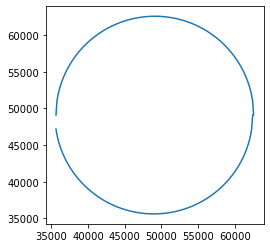

In [12]:
# create circular polygons around the well for refinement

x0,y0 = make_circle(7*delr)
x1,y1 = make_circle(5*delr)
x2,y2 = make_circle(3*delr)
x3,y3 = make_circle(1*delr)
plt.plot(x0,y0)
plt.axis('square')

## Make refinement features and map to the shapefiles that gridgen will make

In [16]:
x0

array([35612.5 , 35747.25, 35882.  , 36016.75, 36151.5 , 36286.25,
       36421.  , 36555.75, 36690.5 , 36825.25, 36960.  , 37094.75,
       37229.5 , 37364.25, 37499.  , 37633.75, 37768.5 , 37903.25,
       38038.  , 38172.75, 38307.5 , 38442.25, 38577.  , 38711.75,
       38846.5 , 38981.25, 39116.  , 39250.75, 39385.5 , 39520.25,
       39655.  , 39789.75, 39924.5 , 40059.25, 40194.  , 40328.75,
       40463.5 , 40598.25, 40733.  , 40867.75, 41002.5 , 41137.25,
       41272.  , 41406.75, 41541.5 , 41676.25, 41811.  , 41945.75,
       42080.5 , 42215.25, 42350.  , 42484.75, 42619.5 , 42754.25,
       42889.  , 43023.75, 43158.5 , 43293.25, 43428.  , 43562.75,
       43697.5 , 43832.25, 43967.  , 44101.75, 44236.5 , 44371.25,
       44506.  , 44640.75, 44775.5 , 44910.25, 45045.  , 45179.75,
       45314.5 , 45449.25, 45584.  , 45718.75, 45853.5 , 45988.25,
       46123.  , 46257.75, 46392.5 , 46527.25, 46662.  , 46796.75,
       46931.5 , 47066.25, 47201.  , 47335.75, 47470.5 , 47605

In [14]:
g.add_refinement_features([[list(zip(x0,y0))]], 'polygon', 1, range(nlay))
rf0shp = os.path.join(model_dir, 'rf0')

g.add_refinement_features([[*list(zip(x1,y1))]], 'polygon', 2, range(nlay))
rf1shp = os.path.join(model_dir, 'rf1')

g.add_refinement_features([[*list(zip(x2,y2))]], 'polygon', 3, range(nlay))
rf2shp = os.path.join(model_dir, 'rf2')

g.add_refinement_features([[*list(zip(x3,y3))]], 'polygon', 4, range(nlay))
rf3shp = os.path.join(model_dir, 'rf3')


TypeError: 'numpy.float64' object is not iterable

## let's take a look at the refinement levels

In [ ]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(model=gwffake)#, extent = (30 * delr,70 * delr,30 * delc, 70 * delc))
mm.plot_grid()
fp.plot.plot_shapefile(rf0shp, ax=ax, facecolor='blue', edgecolor='none')
fp.plot.plot_shapefile(rf1shp, ax=ax, facecolor='yellow', edgecolor='none')
fp.plot.plot_shapefile(rf2shp, ax=ax, facecolor='pink', edgecolor='none')
fp.plot.plot_shapefile(rf3shp, ax=ax, facecolor='red', edgecolor='none')

## Now build the grid using the `build()` method on the `Gridgen` object

In [ ]:
g.build()

### ... and plot up the refined grid

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5)
plt.xlim((21*delr,31*delr))
plt.ylim((31*delc,21*delc))

### `gridgen` will provide all the properties we will need to define a `disv` discretization object

In [ ]:
gridprops = g.get_gridprops_disv()
ncpl = gridprops['ncpl']
top = gridprops['top']
botm = gridprops['botm']
nvert = gridprops['nvert']
vertices = gridprops['vertices']
cell2d = gridprops['cell2d']


In [ ]:
# initial conditions
ic = fp.mf6.ModflowGwfic(gwf, pname='ic', strt=0.)

In [ ]:
ic

In [ ]:
dis

In [ ]:
# disv
disv = fp.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, 
                                top=0, botm=botm, 
                                nvert=nvert, vertices=vertices, 
                                cell2d=cell2d)

### `cell2d` is a list of tuples containing node information including number, x,y, and connections

In [ ]:
cell2d

## We can use a little trickery to find all the edge cells at which we will apply a constant head value, pulling values from `cell2d` at the x and y coordinates of the edges of the domain

In [ ]:
chd_spd = [i for i in cell2d if i[1] == delr/2] + \
[i for i in cell2d if i[2] == delr/2] + \
[i for i in cell2d if i[1] == ((nrow * delr-1)+delr/2)] + \
[i for i in cell2d if i[2] == ((nrow * delr-1)+delr/2)] 


In [ ]:
chd_spd

## A little more trickery - use `list(set())` to remove duplicates (at corners from above)
## Then set up the list of layers, nodenumbers, and chd values that will supply the chd package

In [ ]:
print(len(chd_spd))
chd_spd = list(set(chd_spd))
chd_spd = [[[0,i[0]],0] for i in chd_spd]
print(len(chd_spd))


In [ ]:
chd_spd

### We need a few more packages defined to run this

In [ ]:
chd = fp.mf6.ModflowGwfchd(gwf, save_flows=True,stress_period_data = chd_spd)

In [ ]:
# npf 
hk=0.3

# node property flow
npf = fp.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                              icelltype=[0], 
                              k=[hk],
                              k33=[hk])

In [ ]:
# storage
ss=0.0008
stor = fp.mf6.ModflowGwfsto(gwf, ss=ss, transient=True)

## Now we need to find the center cell into which to place our pumping well

In [ ]:
x = [i[1] for i in cell2d]
y = [i[2] for i in cell2d]
xc= x==np.median(x)
yc =y==np.median(y)

In [ ]:
center_cell = gwf.modelgrid.intersect(np.median(x),np.median(y))

In [ ]:
# single well in the center
well_sp = [[(0, center_cell), -1.16]]
wel = fp.mf6.ModflowGwfwel(gwf,save_flows=True,stress_period_data=well_sp)

In [ ]:
# output control
oc = fp.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

## Now write the output and run

In [ ]:
sim.write_simulation()
sim.run_simulation()

## read in the head values and plot them

In [ ]:
fname = os.path.join(model_dir, model_name + '.hds')
hdobj = fp.utils.HeadFile(fname)
head = hdobj.get_alldata()

In [ ]:
head.shape

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(gwf, ax=ax)
xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
v=mm.plot_array(head[74,0,0:])
plt.xlim((xmid-2550,xmid+2500))
plt.ylim((ymid-2000,ymid+2100))
plt.colorbar(v, shrink=.50)


In [ ]:
# turn on XT3D in npf package to compare results
gwf.npf.xt3doptions=True
gwf

### Write and run now with XT3D enabled

In [ ]:
sim.write_simulation()
sim.run_simulation()

### Read in the heads again with XT3D and look at the difference on the final timestep

In [ ]:
fname = os.path.join(model_dir, model_name + '.hds')
hdobj2 = fp.utils.HeadFile(fname)
head2 = hdobj2.get_alldata()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(gwf, ax=ax)
xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
v=mm.plot_array(head[74,0,0:]-head2[74,0,0:])
plt.xlim((xmid-2550,xmid+2550))
plt.ylim((ymid-2100,ymid+2100))
plt.colorbar(v)

## Now we can compare with our analytical solution
### First let's get the times from the head file to be sure we align times correctly

In [ ]:
alltimes = hdobj.get_times()

### Then import and run the Theis script

In [ ]:
import theis_script2

In [ ]:
dd_analytical = theis_script2.theis_analytical(alltimes)

## Plot a PDF with one time step per page

In [ ]:
if os.path.exists('tmp_images'):
    shutil.rmtree('tmp_images')
os.mkdir('tmp_images')
# make a temporary directory for the images.

In [ ]:
with PdfPages('theis_modflow_unstructured_circ_analytical.pdf') as pdfout:
    for i in range(len(alltimes)):
        # plot the MODFLOW6 head field
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(121)
        mm = fp.plot.PlotMapView(gwf, ax=ax)
        ax.set_aspect('equal')
        xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
        v=mm.plot_array(-head[i,0,:],vmin=0,vmax=1.7, cmap='magma')
        ax.set_xlim((xmid-1050,xmid+1050))
        ax.set_ylim((ymid-1050,ymid+1050))
        plt.title('MODFLOW6 Unstructured')

        # plot the analytical solution
        fig.add_subplot(122)
        plt.imshow(dd_analytical[i], interpolation='nearest',
                  vmin=0,
                  vmax=1.7, cmap='magma')
        plt.title('Analytical')
        plt.suptitle('Theis two ways: timestep = {0}'.format(i+1))
        plt.tight_layout()
        
        pdfout.savefig()
        plt.savefig('tmp_images/{0}.png'.format(i))
        
        plt.close()

## Or we can make a movie using `ffmpeg`

In [ ]:
# make a .mpeg
import imageio
import imageio_ffmpeg

mp4_path = 'modflow_theis_unstruc_circ.mp4'
frames_path = 'tmp_images/{i}.png'

with imageio.get_writer(mp4_path, mode='I') as writer:
    for i in range(len(alltimes)):
        writer.append_data(imageio.imread(frames_path.format(i=i)))

### We can also evaluate the errors with and without `xt3d` over simulation time

In [ ]:
with PdfPages('errors_circular.pdf') as pdfout:
    for i in range(len(alltimes)):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1, aspect='equal')
        mm = fp.plot.PlotMapView(gwf, ax=ax)
        xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
        v=mm.plot_array(head[i,0,0:]-head2[i,0,0:])
        plt.xlim((xmid-2550,xmid+2550))
        plt.ylim((ymid-2100,ymid+2100))
        plt.colorbar(v, shrink=0.5)
        plt.title('errors')
        plt.tight_layout()
        
        pdfout.savefig()
        plt.close()